# Question 2
In this notebook we will train a model to generate captions for images in COCO dataset. Many ideas used in this notebook derive from [this paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7505636).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# NOTE: YOU MUST CHANGE THIS DIRECTORY RELATIVELY TO YOUR OWN PREFERENCE
%cd /content/drive/MyDrive/Colab\ Notebooks/Deep \Learning/Hw4/Q2

/content/drive/MyDrive/Colab Notebooks/Deep Learning/Hw4/Q2


## Packages

In [3]:
!pip install pycocotools

import math
from data_loader import get_loader
from pycocotools.coco import COCO
from torchvision import transforms
from tqdm.notebook import tqdm
import torch.nn as nn
import torch
import torch.utils.data as data
import os
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Build Encoder and Decoder

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        # Only fine-tune the last layer
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()

        self.hidden_dim = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))

    def forward(self, features, captions):
        cap_embedding = self.embed(
            captions[:, :-1]
        embeddings = torch.cat((features.unsqueeze(dim=1), cap_embedding), dim=1)

        lstm_out, self.hidden = self.lstm(embeddings) 
        outputs = self.linear(lstm_out)  

        return outputs

    def sample(self, inputs, states=None, max_len=20):
        res = []

        for i in range(max_len):
            lstm_out, states = self.lstm(inputs, states) 
            outputs = self.linear(lstm_out.squeeze(dim=1))  
            _, predicted_idx = outputs.max(dim=1) 
            res.append(predicted_idx.item())
            if predicted_idx == 1:
                break
            inputs = self.embed(predicted_idx) 
            inputs = inputs.unsqueeze(1)  

        return res


## Download COCO Dataset

In [6]:
%cd /content
!mkdir cocoapi
!mkdir cocoapi/images

/content


In [7]:
!wget -c http://images.cocodataset.org/zips/train2014.zip 
!wget -c http://images.cocodataset.org/zips/val2014.zip
!wget -c http://images.cocodataset.org/zips/test2014.zip

--2023-02-05 17:07:00--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.164.209, 52.217.109.100, 3.5.19.134, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.164.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  15.0MB/s    in 11m 34s 

2023-02-05 17:18:34 (18.6 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]

--2023-02-05 17:18:34--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.83.60, 52.217.168.177, 54.231.167.105, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.83.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]

In [8]:
!unzip -o -q train2014.zip -d cocoapi/images
!unzip -o -q val2014.zip -d cocoapi/images
!unzip -o -q test2014.zip -d cocoapi/images

In [9]:
!wget -c http://images.cocodataset.org/annotations/image_info_test2014.zip
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip -o image_info_test2014.zip -d cocoapi
!unzip -o annotations_trainval2014.zip -d cocoapi

--2023-02-05 17:34:33--  http://images.cocodataset.org/annotations/image_info_test2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.160.17, 54.231.171.33, 52.217.48.244, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.160.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 763464 (746K) [application/zip]
Saving to: ‘image_info_test2014.zip’

image_info_test2014 100%[===================>] 745.57K  --.-KB/s    in 0.1s    

2023-02-05 17:34:34 (5.08 MB/s) - ‘image_info_test2014.zip’ saved [763464/763464]

--2023-02-05 17:34:34--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.160.17, 54.231.171.33, 52.217.48.244, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.160.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_tr

## Setup Training

We compose the transformation in a way that suits ResNet. This pre-trained model takes 224x224 images as input, and we normalize the inputs with the relative constants brought below.

In [10]:
transform = dict()
transform['train'] = transforms.Compose(
    [   transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),  
            (0.229, 0.224, 0.225),
        ),
    ]
)

transform['test'] = transforms.Compose(
    [
        transforms.Resize(256),  
        transforms.RandomCrop(224), 
        transforms.ToTensor(),  
        transforms.Normalize(
            (0.485, 0.456, 0.406),  
            (0.229, 0.224, 0.225),
        ),
    ]
)

In [11]:
# Build data loader
cocoapi_loc = r""

data_loader = get_loader(
    transform=transform['train'],
    mode="train",
    batch_size=256,
    vocab_threshold=5,
    vocab_from_file=False,
    cocoapi_loc=cocoapi_loc,
)

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:42<00:00, 9643.36it/s] 


In [12]:
# BUILD THE MODEL
vocab_size = len(data_loader.dataset.vocab)
encoder = EncoderCNN(embed_size=128)
decoder = DecoderRNN(embed_size=128,
                     hidden_size=256,
                     vocab_size=vocab_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)
print(f'Running on {device}')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Running on cuda


In [13]:
params = list(decoder.parameters()) + list(encoder.embed.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)
criterion = (nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss())

# Training the model


In [14]:
hw_dir = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/Hw4/Q2"
model_dir = os.path.join(hw_dir, "/models")
os.makedirs(model_dir, exist_ok=True)

In [ ]:
num_epochs = 3                
save_every = 100              
print_every = 5               
total_step = math.ceil(len(data_loader.dataset) / data_loader.batch_sampler.batch_size)

for epoch in range(1, num_epochs + 1):
    for step in range(1, total_step + 1):

        indices = data_loader.dataset.get_train_indices()
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler

        images, captions = next(iter(data_loader))
        images = images.to(device)
        captions = captions.to(device)

        decoder.zero_grad()
        encoder.zero_grad()

        # FORWARD PASS
        features = encoder(images)
        outputs = decoder(features, captions)

        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        # BACKWARD PASS
        loss.backward()

        # UPDATE THE PARAMETERES
        optimizer.step()

        if step % print_every == 0:
            print(f"[{step}/{total_step}] training_loss: {loss.item():2.4f}, perplexity: {np.exp(loss.item()):4.2f}")
        if step % save_every == 0:
            PATH_DECODER = hw_dir + f"/models/decoder-{step}.pkl"
            PATH_ENCODER = hw_dir + f"/models/encoder-{step}.pkl"
            torch.save(
                decoder.state_dict(), PATH_DECODER
            )
            torch.save(
                encoder.state_dict(), PATH_ENCODER
            )

In [ ]:
torch.save(decoder.state_dict(), os.path.join(model_dir, 'decoder-final.pkl'))
torch.save(encoder.state_dict(), os.path.join(model_dir, 'encoder-final.pkl'))

# Testing the model

In [17]:
# Setup the dataloader
cocoapi_dir = r""
data_loader = get_loader(transform=transform['test'],
                         mode="test",
                         cocoapi_loc=cocoapi_dir)

Vocabulary successfully loaded from vocab.pkl file!


In [59]:
embed_size = 256
hidden_size = 512
vocab_size = len(data_loader.dataset.vocab)

# Determine the paths
PATH = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/Hw4/Q2/models/"
encoder_file = PATH + "encoder-1080.pkl"
decoder_file = PATH + "decoder-1080.pkl"


encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Test mode
encoder.eval()
decoder.eval()

encoder.load_state_dict(torch.load(encoder_file))
decoder.load_state_dict(torch.load(decoder_file))

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)
print(f"Running on {device}")

Running on cuda


In [5]:
def clean_sentence(output, idx2word):
    sentence = ""
    for i in output:
        word = idx2word[i]
        if i == 0:
            continue
        if i == 1:
            break
        if i == 18:
            sentence = sentence + word
        else:
            sentence = sentence + " " + word
    return sentence

In [77]:
def predict_caption(image, idx2word=data_loader.dataset.vocab.idx2word):
    image = transform['test'](image).unsqueeze(0)
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)

    sentence = clean_sentence(output, idx2word)
    ax = plt.axes()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.imshow(np.squeeze(orig_image))
    plt.xlabel(sentence, fontsize=12)
    plt.show()

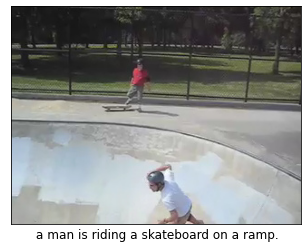

In [58]:
orig_image, _ = next(iter(data_loader))
predict_caption(image=orig_image)